In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Read HS

In [24]:
hs = np.load('../total_hyp_ref.npy').squeeze().reshape(580, 890, 47)
print(hs.shape)
# wvls = np.linspace(430,660,47)
# print(wvls, len(wvls))
# for i in range(47):
#     plt.imshow(hs[:,:,i], vmin =0, vmax = 1), plt.title('%dnm'%wvls[i]), plt.colorbar()
#     plt.show()

(580, 890, 47)


In [25]:
# hs = np.load('../total_hyp_ref_1011(2).npy').squeeze().reshape(580, 890, 47)
# print(hs.shape)
# wvls = np.linspace(430,660,47)
# print(wvls, len(wvls))
# for i in range(47):
#     plt.plot(hs[150,380]), plt.title('%dnm'%wvls[i])
#     plt.plot(hs[150,420]), plt.title('%dnm'%wvls[i]), plt.colorbar()

#     plt.show()

# Functions for HS2sRGB

In [26]:
cmf_path = './judd_vos.txt'

cmf = np.loadtxt(cmf_path, usecols=(1, 2, 3))

illum_path = './d65.txt'
illum = np.loadtxt(cmf_path, usecols=(1, ))

d65_xyz = np.array([0.95047, 1.0, 1.08883])

M = np.array([[3.2406, -1.5372, -0.4986],
              [-0.9689, 1.8758, 0.0415],
              [0.0557, -0.2040, 1.0570]])


In [27]:

def xyz2srgb(xyz, gamma=2.2):
    sRGB = np.tensordot(xyz, M.transpose(), [2, 0])
    sRGB[sRGB > 1] = 1
    sRGB[sRGB < 0] = 0

    RGB = sRGB ** (1 / gamma)

    RGB[RGB > 1] = 1
    RGB[RGB < 0] = 0

    return RGB


def spec_to_xyz(spectrum: np.ndarray,
                wvls: np.ndarray,
                illuminant: np.ndarray):
    cmf_indicies = (np.squeeze(wvls).astype(np.uint32) - 380) // 1
    illum_indices = (np.squeeze(wvls).astype(np.uint32) - 380) // 1
    cmf_matrix = cmf[cmf_indicies, :]
    if cmf_matrix.ndim == 1:
        cmf_matrix = np.expand_dims(cmf_matrix, 0)
    illum_matrix = illuminant[illum_indices]
    matrix = cmf_matrix.T# * illum_matrix.T

    # if spectrum.shape[-1] != matrix.T.shape[-1]
    #     matrix

    xyz = (spectrum @ matrix.T)

    # xyz = xyz / np.sum(xyz)
    k = 100 / (cmf_matrix[:, 1] * illum_matrix).sum()
    xyz = xyz * k
    xyz[xyz < 0] = 0
    return xyz


def whitebalance(ref_xyz: np.ndarray):
    mmean = ref_xyz.mean(axis=(0, 1))
    maxY = ref_xyz[:, :, 1].max()
    ref_xyzw = mmean * (maxY / mmean[1])
    # ref_xyzw = mmean * (1 / mmean[1])
    return ref_xyz / ref_xyzw


# rad_x: numpy (N,M,C), tensor (C,N,M)
# wvls: [400, 410, ..., 700] nm
def hs2srgb(rad_x, wvls,
            refwhite=None, illuminant=illum, output_mode_HWC=False,
            gamma=2.2):


    rad_x[rad_x < 0] = 0
    rad_x[rad_x > 1] = 1
    if refwhite is not None:
        refco = 0.9781
        refwhite2 = refwhite / refco

        ref_x = rad_x / refwhite2
        whiteref = refwhite / refwhite2
    else:
        ref_x = rad_x

    ref_xyz = spec_to_xyz(ref_x, wvls, illuminant)

    do_WB = True
    if do_WB:
        if refwhite is not None:
            white_xyz = spec_to_xyz(whiteref, wvls, illuminant)
            ref_xyzw = ref_xyz / white_xyz
        else:
            ref_xyzw = whitebalance(ref_xyz)
    else:
        ref_xyzw = ref_xyz

    wpD65 = d65_xyz
    ref_xyzw = ref_xyzw * wpD65

    srgb = xyz2srgb(ref_xyzw, gamma)
    if output_mode_HWC:
        return srgb
    else:
        return np.transpose(srgb, (2,0,1))

# Contrast adjustment in HS

In [28]:
wvls = np.linspace(430,660,47)
vmin = 0.0
vmax = 1.0
hs_s = (hs - vmin)/(vmax-vmin)
hs_s[hs_s<0]=0
hs_s[hs_s>1]=1


# HS2sRGB

In [29]:
# white_min_x = 580
# white_max_x = 620
# white_min_y = 490
# white_max_y = 540
# white_spec = hs_s[white_min_y:white_max_y, white_min_x:white_max_x, :].mean(axis=(0,1))
# plt.plot(white_spec)
# # srgb = hs2srgb(hs_s, wvls, output_mode_HWC=True, refwhite=white_spec)
srgb = hs2srgb(hs_s, wvls, output_mode_HWC=True)


In [30]:
srgb.shape

(580, 890, 3)

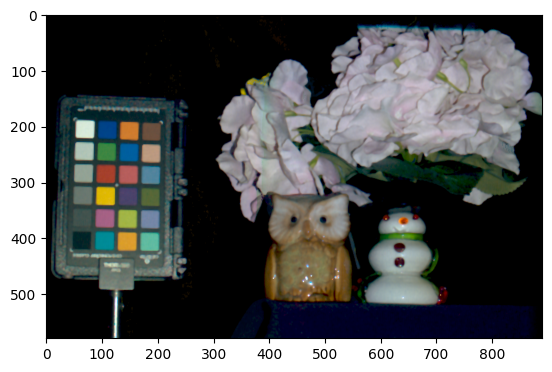

In [31]:
plt.imshow(srgb)

In [32]:
import cv2

cv2.imwrite('srgb.png', srgb[:,:,::-1]*255)

True

# Contrast adjustment on sRGB

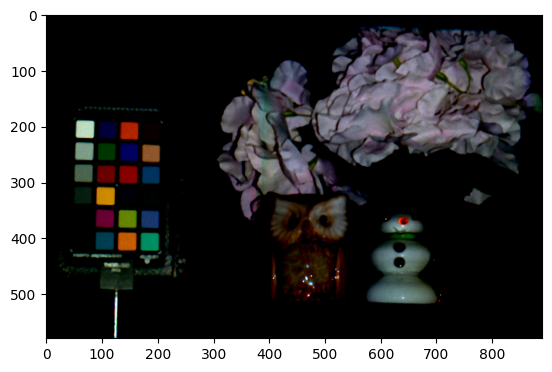

In [33]:
vmin = 0.4
vmax = 1.0
srgb_s = (srgb - vmin)/(vmax-vmin)
srgb_s[srgb_s<0]=0
srgb_s[srgb_s>1]=1

plt.imshow(srgb_s)